In [1]:
#%matplotlib inline
%pylab inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs

from gsw import SA_from_SP, p_from_z, CT_from_pt, rho
from gsw import alpha, beta, cp_t_exact

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cosima_cookbook as cc
session = cc.database.create_session()

###Importing General Variables and relevant constants

In [3]:
#Input all data needed from the model for tenth degree
expt = '01deg_jra55v13_ryf9091'
x_u = cc.querying.getvar(expt,'xu_ocean',session,n=1).sel(xu_ocean=slice(-90,10))
x_t = cc.querying.getvar(expt,'xt_ocean',session,n=1).sel(xt_ocean=slice(-90,10))
y_u = cc.querying.getvar(expt,'yu_ocean',session,n=1).sel(yu_ocean=slice(10,65))
y_t = cc.querying.getvar(expt,'yt_ocean',session,n=1).sel(yt_ocean=slice(10,65))
z_t = cc.querying.getvar(expt,'st_ocean',session,n=1)

In [4]:
r0 = 6.371 * 10**6
av = 7.2921159 * 10**(-5)
rho_0 = 1026
g = 9.81
f = 2*av*np.sin((y_t*np.pi)/180)  #Coriolis Parameter

## Calculating the mechanical component of generalized potential vorticity flux:
1. Find in-situ density from salinity and temperature using the equation of state
2. Obtain frictional velocity using the formula: $u^{*} = \Big( \frac{|\tau|}{\rho} \Big)^{0.5}$
3. The mixed layer depth is given by the following relation:
\begin{equation}
    \delta_e = \frac{0.4 u^{*}}{f}
\end{equation}
4. Take the vertical component of cross product of the wind stress and surface potential density gradient, referenced to 0 dbar.
5. $J_{zf}$ is evaluated as:
\begin{equation}
    J_{zf} = \frac{\hat{k} \cdot (\tau \times \nabla \sigma)}{\rho_0 \delta_e}
\end{equation}

In [5]:
#1. Finding in-situ density
salt = cc.querying.getvar(expt,'salt',session,start_time='1996-01-01',end_time='2000-12-31').sel(
    xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65)).sel(st_ocean = 1, method = 'nearest')
T = cc.querying.getvar(expt,'temp',session,start_time='1996-01-01',end_time='2000-12-31').sel(
    xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65)).sel(st_ocean = 1, method = 'nearest')
Y,Z,X =  np.meshgrid(y_t,z_t,x_t)
pressure_array = xr.DataArray(p_from_z(-Z,Y),  coords = [z_t, y_t, x_t],  
                              dims = ['st_ocean','yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
pressure_array_NA = pressure_array.sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65)).sel(st_ocean = 1,method = 'nearest')
rho_mat = rho(salt,T-273.15,pressure_array_NA)
#rho_mat.mean('time').plot.contourf(levels = np.linspace(1020,1032,41))

In [6]:
#2. Interpolating wind stress to centred coordinates to calculate Ekman Layer Depth 
import xgcm
tau_x = cc.querying.getvar(expt,'tau_x',session,start_time='1996-01-01',end_time='2000-12-31').sel(
    yu_ocean=slice(10,65)).sel(xu_ocean=slice(-90,10))
tau_y = cc.querying.getvar(expt,'tau_y',session,start_time='1996-01-01',end_time='2000-12-31').sel(
    yu_ocean=slice(10,65)).sel(xu_ocean=slice(-90,10))

tau_x = tau_x.rename('Wind stress in x direction')
tau_y = tau_y.rename('Wind stress in y direction')
paths = []
paths.append("/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf9091_gadi_retest/output328/ocean/ocean.nc")
data = xr.merge((tau_x,tau_y,T))
data.coords['xt_ocean'].attrs.update(axis='X')
data.coords['xu_ocean'].attrs.update(axis='X',c_grid_axis_shift = 0.5)
#data.coords['xu_ocean'].attrs.update(axis='X')
data.coords['yt_ocean'].attrs.update(axis='Y')
data.coords['yu_ocean'].attrs.update(axis='Y',c_grid_axis_shift = -0.5)
#data.coords['yu_ocean'].attrs.update(axis='Y')
data.coords['st_ocean'].attrs.update(axis='Z')

temp = xgcm.Grid(data, periodic=['X'])
tempo = temp.interp(tau_x,'X')
tau_x_interp = temp.interp(tempo,'Y',boundary="extend")

temp = xgcm.Grid(data, periodic=['Y'])
tempo = temp.interp(tau_y,'Y')
tau_y_interp = temp.interp(tempo,'X',boundary="extend")

In [7]:
#2-3. Calculate Ekman Layer Depth
taumag = (tau_x_interp**2 + tau_y_interp**2)**0.5
abs_tau = abs(taumag)
ustar = (abs_tau/rho_mat)**0.5
ELD = 0.4*(ustar/f)

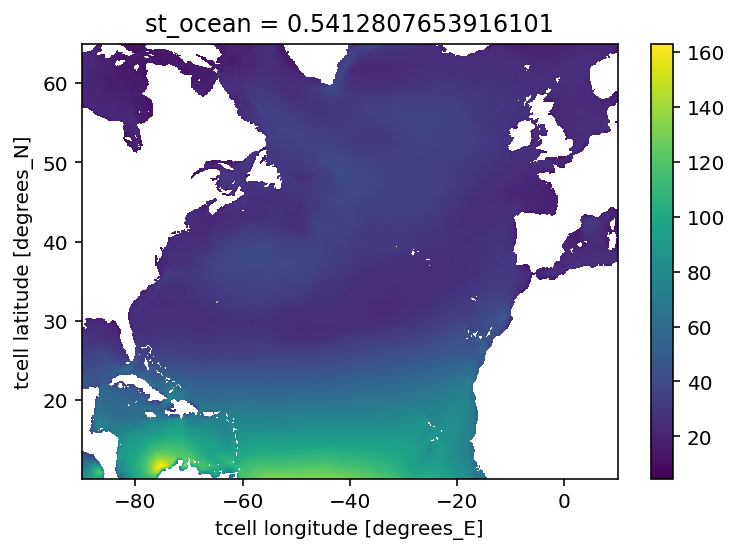

In [8]:
ELD.mean('time').plot()

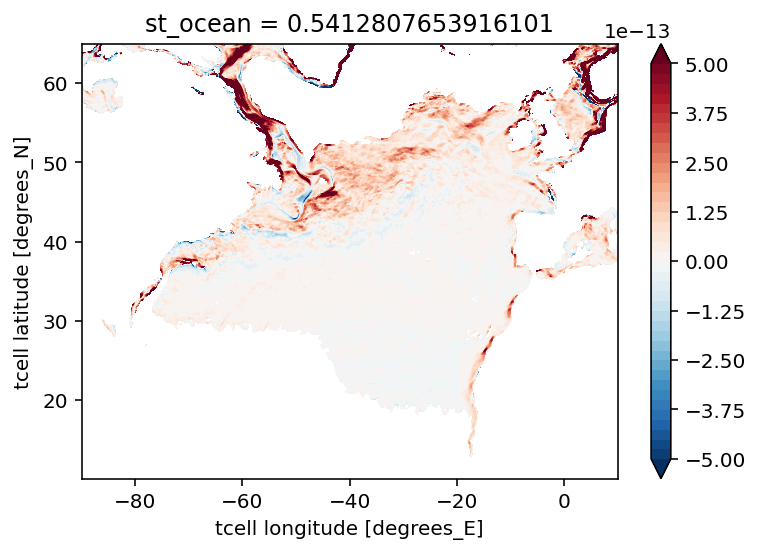

In [9]:
#4-5. Cross product and mechanical component of Jzf
sigma = 26
extn = 0.25
potrho = cc.querying.getvar(expt,'pot_rho_0',session,start_time='1996-01-01',end_time='2000-12-31').sel(
    yt_ocean=slice(10,65)).sel(xt_ocean=slice(-90,10)).sel(st_ocean = 1,method = 'nearest') - 1000

Gradx_potrho = potrho.differentiate('xt_ocean')/(r0*np.cos((potrho.yt_ocean*np.pi)/180))
Grady_potrho = potrho.differentiate('yt_ocean')/r0
Jzf = (tau_x_interp*Grady_potrho - tau_y_interp*Gradx_potrho)/(rho_mat*ELD)
Jzf_clip = Jzf.where((potrho.values >= (sigma - extn)) & (potrho.values <= (sigma + extn)))
Jzf_clip.fillna(0)
Jzf_clip.mean('time').plot.contourf(levels = np.linspace(-5e-13,5e-13,41))

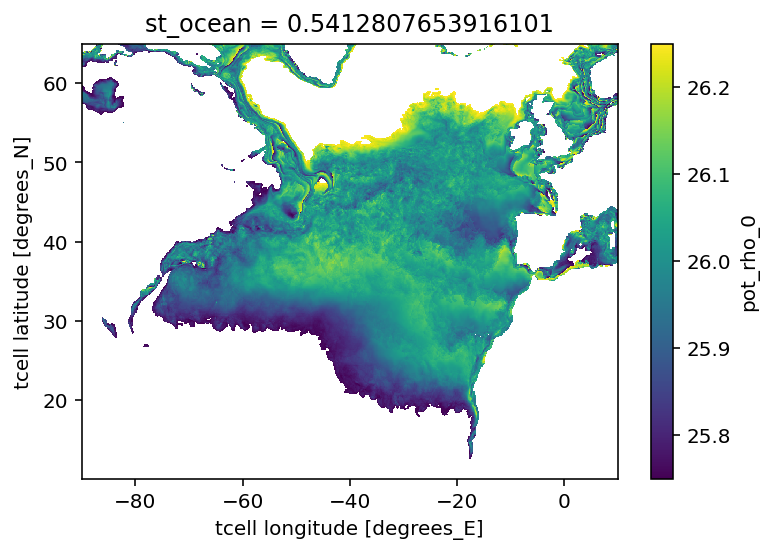

In [10]:
#Extra -> Checking region of particular sigma
potrho_clip = potrho.where((potrho.values >= (sigma - extn)) & (potrho.values <= (sigma + extn)))
potrho_clip.mean('time').plot()

## Calculating the eddy entrainment component of generalized potential vorticity flux: 
1. $J_{zw}$ is evaluated as:
\begin{equation}
    J_{zw} = \frac{0.7 f \rho u_{*}^{3}}{gh_{MLD}^2}
\end{equation}

The mixed layer depth h is present as a model output. All of the other variables needed to evaluate $J_{zw}$ are already present.

In [11]:
vars_01deg = cc.querying.get_variables(session, experiment=expt)
vars_01deg[vars_01deg['name'].str.lower().str.match('mld')]

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
82,mld,mixed layer depth determined by density criteria,1 daily,output928/ocean/ocean_daily.nc,732,1950-01-01 00:00:00,2133-04-01 00:00:00
163,mld,mixed layer depth determined by density criteria,1 monthly,output928/ocean/ocean_month.nc,929,1900-01-01 00:00:00,2133-04-01 00:00:00


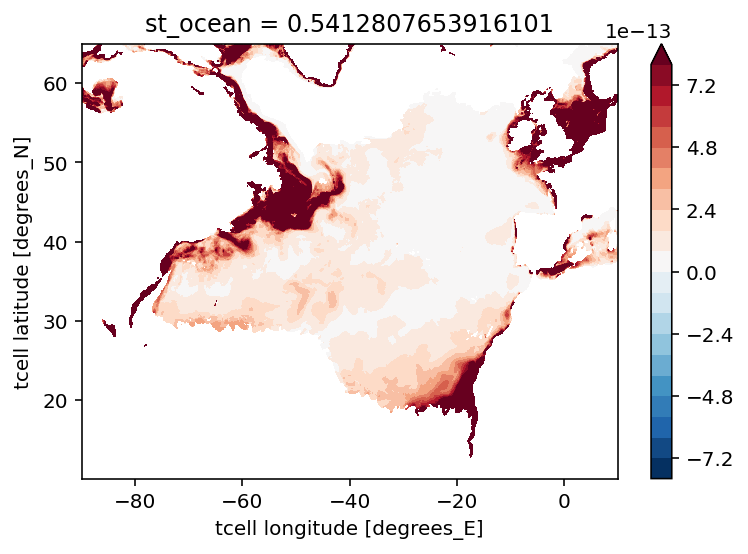

In [12]:
#1. Evaluating eddy entrainment component using fixed mixed layer depth (winter MLD)

MLD = cc.querying.getvar(expt,'mld',session,n=1).sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65)).mean('time')

Jzw_fixed = (0.7*rho_mat*f*ustar**3)/(g*MLD**2)
Jzw_fixed_clip = Jzw_fixed.where((potrho.values >= (sigma - extn)) & (potrho.values <= (sigma + extn)))
Jzw_fixed_clip.mean('time').plot.contourf(levels = np.linspace(-8e-13,8e-13,21))

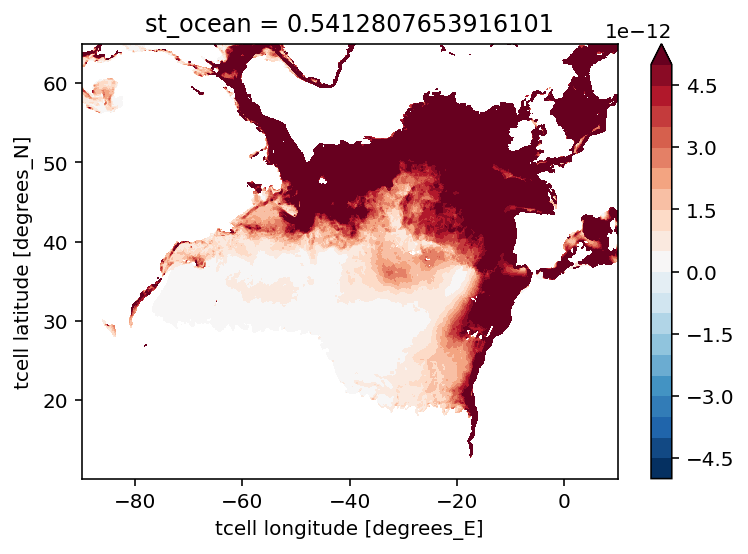

In [13]:
#1. Evaluating eddy entrainment component using seasonal mixed layer depth

MLD2 = cc.querying.getvar(expt,'mld',session,ncfile='ocean_month.nc',start_time='1996-01-01',end_time='2000-12-31').sel(
    xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65))

Jzw = (0.7*rho_mat*f*ustar**3)/(g*MLD2**2)
Jzw_clip = Jzw.where((potrho.values >= (sigma - extn)) & (potrho.values <= (sigma + extn)))
Jzw_clip.mean('time').plot.contourf(levels = np.linspace(-5e-12,5e-12,21))

## Calculating the buoyancy component of generalized potential vorticity flux: 
1. TEOS-10 is based on a Gibbs function formulation from which all thermodynamic properties of seawater. We use three functions of TEO-10 to get the thermal($\alpha$) and haline($\beta$) expansion coefficients, and specific heat capacity of water. 
2. We need to estimate the air-sea heat flux. In ACCESS-OM2, the total heat flux into the ocean from surface forcing and ice-ocean exchanges is given by the sum of these five terms:
    a. sfc_hflux_coupler
    b. sfc_hflux_pme -> Represents the buoyancy gains due to precipiation and evaporation.
    c. sfc_hflux_from_runoff
    d. sfc_hflux_from_calving
    e. frazil_3d_int_z
3. The mass flux added to the ocean by evaporation and precipitation is be taken into account using the model output variable, pme_river.
4. Finally, specific heat capacity $c_p$ is also estimated using TEOS-10.
5. $J_{zb}$ is evaluated as:
\begin{equation}
    J_{zb} = -\frac{f \alpha Q_{net}}{hc_p} + \frac{f \beta S (E-P)}{h}
\end{equation}


In [14]:
#pme_river -> mass flux of precip-evap+river via sbc
#alpha and beta can be obtained from gsw
#For surface heat flux, check out this page: https://github.com/COSIMA/access-om2/issues/139

In [15]:
#1. Getting alpha, beta and cp from TEOS-10
alpha_mat = alpha(salt,T-273.15,pressure_array_NA)
beta_mat = beta(salt,T-273.15,pressure_array_NA)
cp_mat = cp_t_exact(salt,T-273.15,pressure_array_NA)

In [16]:
#2. Getting surface heat flux from various components.
sfc_heat_coupler = cc.querying.getvar(expt,'sfc_hflux_coupler',session,n=1).sel(
    xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65))
sfc_heat_runoff = cc.querying.getvar(expt,'sfc_hflux_from_runoff',session,n=1).sel(
    xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65))
sfc_heat_pme = cc.querying.getvar(expt,'sfc_hflux_pme',session,n=1).sel(
    xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65))
sfc_heat_frazil = cc.querying.getvar(expt,'frazil_3d_int_z',session,n=1).sel(
    xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65))
total_sfc_hflux = (sfc_heat_coupler + sfc_heat_runoff + sfc_heat_pme + sfc_heat_frazil).mean('time')

In [17]:
#3. Precipitation and evaporation component
pme_river = cc.querying.getvar(expt,'pme_river',session,n=1).sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65)).mean('time')
pme_net = cc.querying.getvar(expt,'pme_net',session,n=1).sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65)).mean('time')
fw_flux = -pme_river #Use pme_river since it has mass flux due to river flow too.

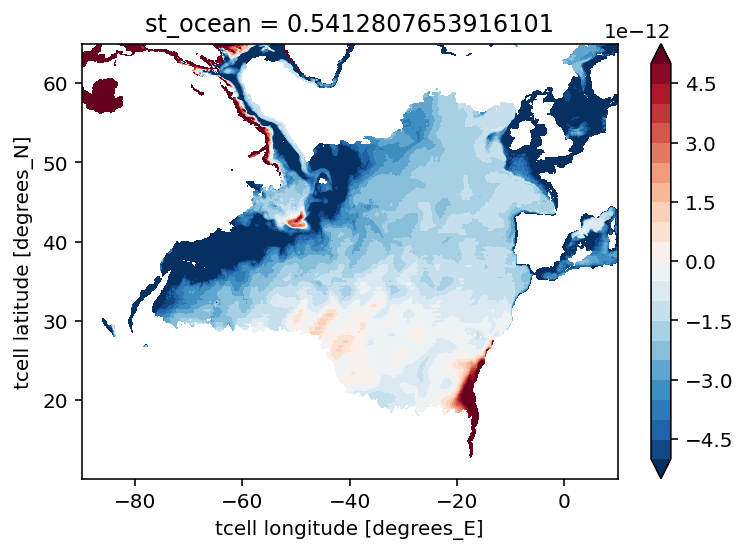

In [18]:
#4. Evaluating buoyancy component of generalized PV flux for fixed MLD
Jzb_fixed = (alpha_mat*total_sfc_hflux*f)/(MLD*cp_mat) + (beta_mat*salt*fw_flux*f)/(MLD)
Jzb_fixed_clip = Jzb_fixed.where((potrho.values >= (sigma - 0.25)) & (potrho.values <= (sigma + 0.25)))
Jzb_fixed_clip.mean('time').plot.contourf(levels = np.linspace(-5e-12,5e-12,21))

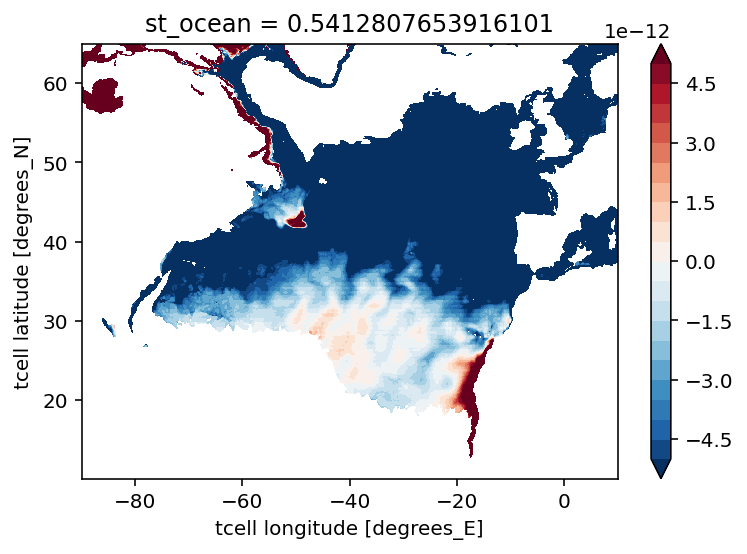

In [19]:
#4. Evaluating buoyancy component of generalized PV flux for seasonal MLD
Jzb = (alpha_mat*total_sfc_hflux*f)/(MLD2*cp_mat) + (beta_mat*salt*fw_flux*f)/(MLD2)
Jzb_clip = Jzb.where((potrho.values >= (sigma - 0.25)) & (potrho.values <= (sigma + 0.25)))
Jzb_clip.mean('time').plot.contourf(levels = np.linspace(-5e-12,5e-12,21))

### Results for all potential densities

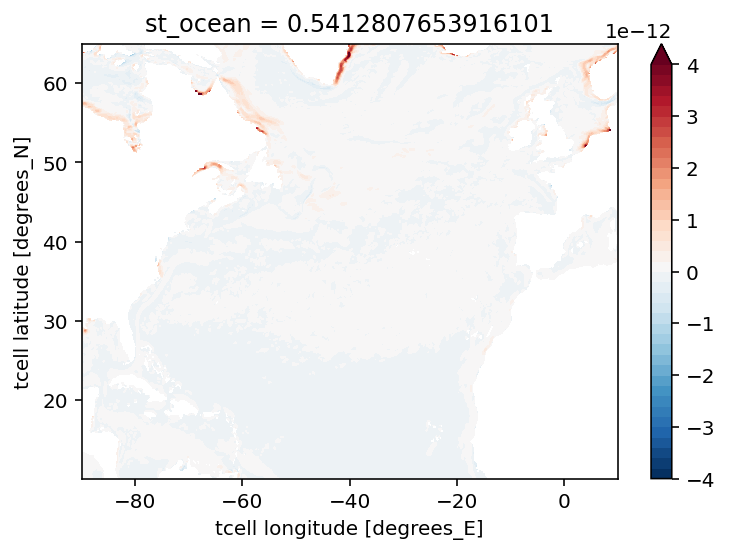

In [20]:
#1. Mechanical component
Jzf.mean('time').plot.contourf(levels = np.linspace(-4e-12,4e-12,41))

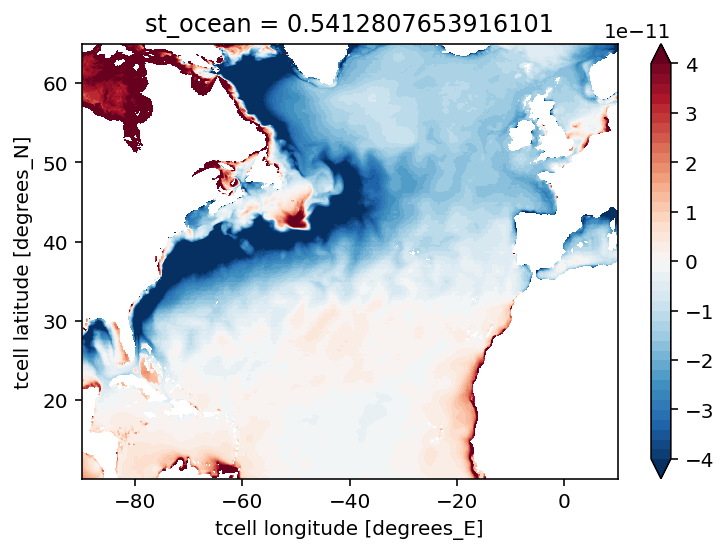

In [21]:
#2. Diabatic component
(Jzb+Jzw).mean('time').plot.contourf(levels = np.linspace(-4e-11,4e-11,41))

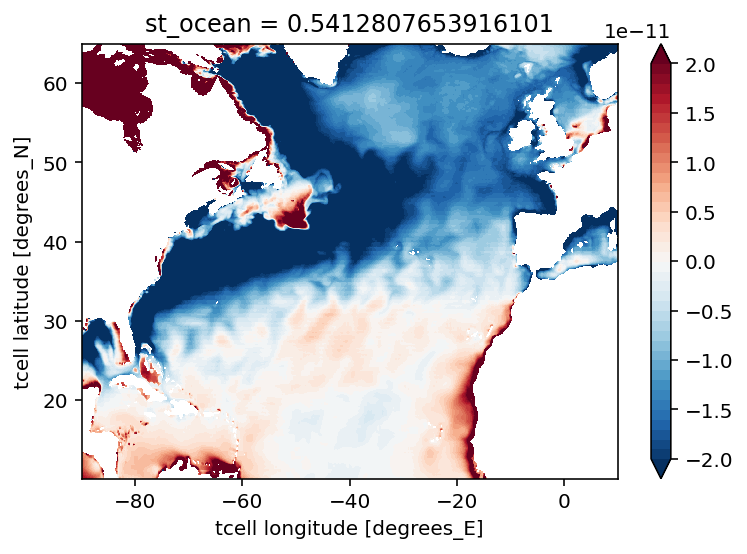

In [22]:
#3. Total PV flux
Jz_total = Jzb + Jzf + Jzw
Jz_total.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,41))

### Summary

1. $J_{zf}$ is very close to results presented by Deremble (this happened after the last update when the potential density gradients were retained in spherical coordinates instead of cartesian coordinates).
2. $J_{zw}$ has similar magnitude and sign but it is not corresponding spatially to the results (similar results were obtained when the MLD was varied seasonally, which is what has been done in the paper too).
3. $J_{zb}$ is still an area of concern, and it has been shown in several papers like Czaja(2009), Deremble(2013), Marshall et al(2001) that this component is the dominant term in the evaluation of buoyancy fluxes. Our results also support this observation, and therefore, a better calculation of diabatic forcing term is needed.

### Some sources of error

1. We compute Jz for each output of the model (30-day sampling) and apply a mask taking values of one on the outcropping window and zero elsewhere. Each of these maps is summed and then divided by the number of maps. The spring migration of the outcrop is faster than the autumn retreat (not shown). At a given point (x, y), it is possible that one day in spring sigma(x, y, t) < 25.75 and 30 days later sigma(x, y, t) > 26.25. In such case there will not be any contribution at this precise location during the spring migration, whereas the real contribution should be f(sigma2 - sigma1). So, there will be an inherent negative bias for entrainment potential vorticity flux, which needs to be taken care of, either by reducing sampling time or increasing outcropping window.
2. The summer MLD is a constant area of concern, because it has a non-linear impact on diabatic and entrainment fluxes. Errors in MLD are amplified during the summer season, and therefore, either a more careful analysis be done for the MLD or a different formulation be created for this forcing.
3. Czaja(2009) dervies the mechanical PV flux by using the MLD, which is in contrast with Deremble's(2013) equation, which uses the Ekman layer depth. What makes matters worse is that these depths have a non-linear relationship with the mechanical PV flux, so the differences are even more strengthened. 

### Future Works

1. Estimating the generalized PV flux by using the original equation:
\begin{equation}
    \textbf{J} = \omega \frac{\partial \sigma}{\partial t} + \frac{\partial \textbf{u}}{\partial t} \times \nabla \sigma + \nabla B \times \nabla \sigma
\end{equation}

2. By having a better temporal resolution, we can further test the validity of the following equation in the GCM:
\begin{equation}
    \frac{\partial}{\partial t} \Big( \rho Q \Big) + \nabla \cdot \textbf(J) = 0
\end{equation}
by estimating the net PV flux using the original equation.

3. To test the validity of these equations, we constrained ourselves to the North Atlantic region. An important extension of this work will be to verify these results for all the global oceans.